In [19]:
# Common
import keras
import numpy as np
import pandas as pd
from glob import glob
from tqdm import tqdm
import tensorflow as tf

# Data
from tensorflow.image import resize
from sklearn.model_selection import StratifiedShuffleSplit
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Data Viz
import seaborn as sns
import matplotlib.pyplot as plt

# TL Model
from tensorflow.keras.applications import ResNet50, ResNet50V2, InceptionV3, Xception, ResNet152, ResNet152V2

# Model
from keras import Sequential
from keras.layers import Conv2D, MaxPool2D, Conv2DTranspose, Dense, Input, Flatten, Dropout, LeakyReLU, Reshape, GlobalAveragePooling2D
from keras.models import load_model, Sequential
from keras.optimizers import Adam

# Callbacks 
from keras.callbacks import EarlyStopping, ModelCheckpoint

# Model Performance
from sklearn.metrics import classification_report

# Model Viz
from tensorflow.keras.utils import plot_model

import os

np.random.seed(42)
tf.random.set_seed(42)

In [2]:
train_set = pd.read_csv (r'./archive/training_set.csv')
test_set = pd.read_csv (r'./archive/testing_set.csv')
train_set.head()

,filename,label
0,Image_1.jpg,sunrise
1,Image_2.jpg,shine
2,Image_3.jpg,cloudy
3,Image_4.jpg,shine
4,Image_5.jpg,sunrise


In [3]:
def load_image(path):
    img = resize(img_to_array(load_img(path))/255., (256,256))
    return img
def show_image(image, title=None):
    plt.imshow(image)
    plt.title(title)
    plt.axis('off')
a = load_image('./archive/train/Image_2.jpg')
a

2023-01-20 21:38:23.354295: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


<tf.Tensor: shape=(256, 256, 3), dtype=float32, numpy=
array([[[0.94476104, 0.9486826 , 0.96829045],
        [0.9411765 , 0.94509804, 0.9647059 ],
        [0.9411765 , 0.94509804, 0.9647059 ],
        ...,
        [0.13333334, 0.29803923, 0.5803922 ],
        [0.13333334, 0.29803923, 0.5803922 ],
        [0.13333334, 0.29803923, 0.5803922 ]],

       [[0.94302475, 0.9469463 , 0.96655416],
        [0.9411765 , 0.94509804, 0.9647059 ],
        [0.9403603 , 0.9442819 , 0.9638897 ],
        ...,
        [0.13143383, 0.29613972, 0.5784927 ],
        [0.13143383, 0.29613972, 0.5784927 ],
        [0.13143383, 0.29613972, 0.5784927 ]],

       [[0.9411291 , 0.94505066, 0.9646585 ],
        [0.940625  , 0.9445466 , 0.9641544 ],
        [0.9391769 , 0.9430985 , 0.9627063 ],
        ...,
        [0.1288603 , 0.2935662 , 0.57591915],
        [0.1288603 , 0.2935662 , 0.57591915],
        [0.1288603 , 0.2935662 , 0.57591915]],

       ...,

       [[0.9411765 , 0.94509804, 0.9529412 ],
        [0.94

In [4]:
train_image_paths = sorted(
    glob('./archive/train'+"/*.jpg"))
test_image_paths = sorted(
    glob('./archive/test'+"/*.jpg"))

print(f"Total Number of Training Images : {len(train_image_paths)} and Testing Images : {len(test_image_paths)}")

Total Number of Training Images : 1048 and Testing Images : 450


In [5]:
train_set.head()

,filename,label
0,Image_1.jpg,sunrise
1,Image_2.jpg,shine
2,Image_3.jpg,cloudy
3,Image_4.jpg,shine
4,Image_5.jpg,sunrise


In [6]:
#adding numerical values to our labels
class_names = sorted(train_set['label'].unique())
class_mappings = {}
for i, name in enumerate(class_names):
    class_mappings[name] =i 
class_mappings, class_names

({'cloudy': 0, 'foggy': 1, 'rainy': 2, 'shine': 3, 'sunrise': 4},
 ['cloudy', 'foggy', 'rainy', 'shine', 'sunrise'])

In [7]:
train_set['label_ids'] = train_set['label'].map(class_mappings)

In [8]:
train_set.head()

,filename,label,label_ids
0,Image_1.jpg,sunrise,4
1,Image_2.jpg,shine,3
2,Image_3.jpg,cloudy,0
3,Image_4.jpg,shine,3
4,Image_5.jpg,sunrise,4


In [13]:
def load_data(labels, root_path):
    
    file_names = labels['filename']#an array storing all the paths of the images in the given set
    class_ids = labels['label_ids']    #an array storing all the labels or the images in the given set

    X = np.zeros(shape=(len(file_names), 256,256,3))#a matrix of size 256,256,3
    y = np.zeros(shape=(len(file_names),1))         #a matrix of size 1 storing our label

    for i, name in tqdm(enumerate(file_names), desc="Loading"):
    
        path = root_path + "/" + name
        
        img = load_image(path) #loading the image as an array of dimension 256x256x3 (since it's an rgb image)
        class_id = class_ids[i] #getting the image class
    
        X[i] = img #assigning to X the array
        y[i] = class_id #label of the image, i.e its class
    
    return X, y

In [14]:
images, labels = load_data(train_set, root_path=
                           './archive/train/')

Loading: 1048it [00:13, 79.57it/s]


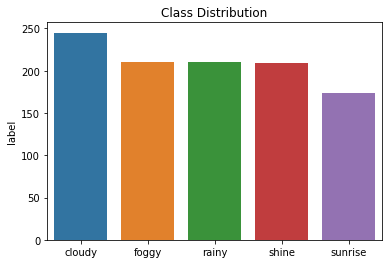

In [15]:
# Class Distribution
class_dis = train_set.label.value_counts()

# Plotting
sns.barplot(x=class_names, y=class_dis)
plt.title("Class Distribution")
plt.show()

In [16]:
# could use data augmentation here too to have more balanced data.
# initialize stratified splitter
split = StratifiedShuffleSplit(n_splits=5, test_size=0.2)

# apply stratified splitting
for train_indicies, test_indicies in split.split(images, labels):
    X_train, y_train = images[train_indicies], labels[train_indicies]
    X_test, y_test = images[test_indicies], labels[test_indicies]

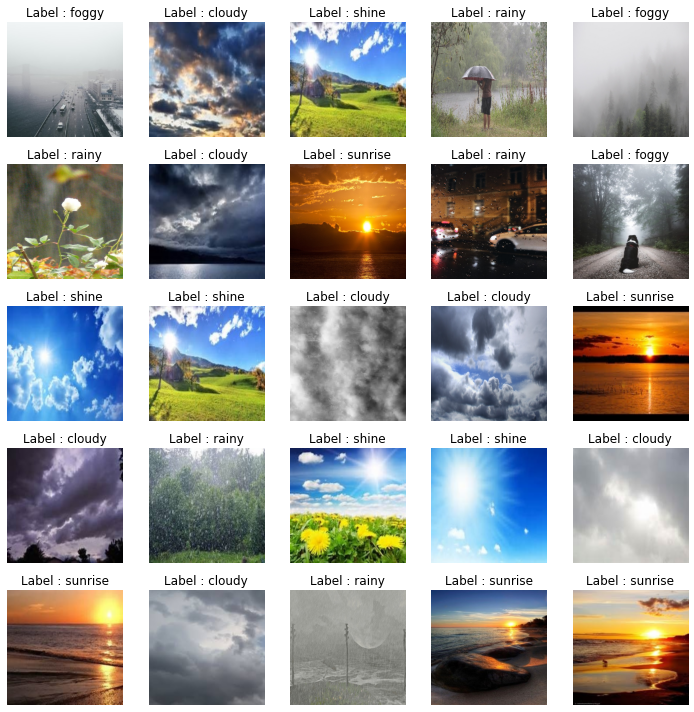

In [17]:
plt.figure(figsize=(10,10))
for i in range(25):
    
    id = np.random.randint(len(images))
    
    image = images[id]
    label = class_names[int(labels[id])]

    plt.subplot(5,5,i+1)
    show_image(image, title=f"Label : {label}")
plt.tight_layout()
plt.show()

In [18]:
#using transfer learning
base =tf.keras.applications.ResNet152(
    include_top=False,
    weights="imagenet",
    input_shape=(256,256,3),
)

base.trainable = False

In [21]:
model1 = Sequential([
    base,#our already trained resnet152
    GlobalAveragePooling2D(),
    Dense(256, activation="relu"),
    Dropout(0.5),
    Dense(len(class_names), activation = "softmax")
])

In [22]:
model1.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)
cbs = [
    EarlyStopping(patience=3, restore_best_weights=True),
    ModelCheckpoint(name+".h5", save_best_only=True)
]

In [ ]:
history = model1.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, callbacks=cbs)

Epoch 1/50
27/27 [==============================] - 274s 10s/step - loss: 1.8095 - accuracy: 0.2100 - val_loss: 1.5882 - val_accuracy: 0.2952
Epoch 2/50
27/27 [==============================] - 238s 9s/step - loss: 1.6138 - accuracy: 0.2411 - val_loss: 1.5710 - val_accuracy: 0.2667
Epoch 3/50
27/27 [==============================] - 247s 9s/step - loss: 1.6018 - accuracy: 0.2494 - val_loss: 1.5671 - val_accuracy: 0.2857
Epoch 4/50
27/27 [==============================] - 316s 12s/step - loss: 1.5735 - accuracy: 0.2721 - val_loss: 1.5507 - val_accuracy: 0.3095
Epoch 5/50
27/27 [==============================] - 295s 11s/step - loss: 1.5532 - accuracy: 0.2983 - val_loss: 1.5434 - val_accuracy: 0.2810
Epoch 6/50
27/27 [==============================] - 239s 9s/step - loss: 1.5486 - accuracy: 0.2876 - val_loss: 1.5329 - val_accuracy: 0.3238
Epoch 7/50
27/27 [==============================] - 238s 9s/step - loss: 1.5324 - accuracy: 0.2852 - val_loss: 1.5258 - val_accuracy: 0.3381
Epoch 8/50